# Analyze patterns

In the previous lesson, you explored your data and learned a little about the spatial and temporal trends of permit activity in Montgomery County. In this lesson, you'll move beyond exploration and run spatial analysis tools to answer specific questions that can't be answered by the data itself. In particular, you want to know why permits spiked in Germantown in 2011 and predict where future permit spikes—and, by extension, future growth—are likely to occur.

First, you'll aggregate the points by ZIP Code. You'll enrich each ZIP Code with demographic information and learn more about the demographic conditions that led to such rapid growth in such a short time. Once you determine why growth occurred where and when it did, you'll locate other ZIP Codes with similar demographic characteristics to predict future growth.

## Aggregate points

In [188]:
from arcgis import *

In [189]:
gis = GIS("https://deldev.maps.arcgis.com", "demo_deldev", "DelDevs12")

In [190]:
data = gis.content.search('title: Commercial Permits since 2010 owner: rpeake_LearnGIS ', 'Feature layer',
                           outside_org=True)

In [191]:
from IPython.display import display

<Item title:"Commercial Permits since 2010" type:Feature Layer Collection owner:rpeake_LearnGIS>
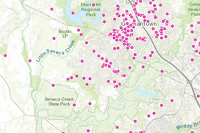

In [192]:
for item in data:
    display(item)

In [193]:
permits = data[0]

In [194]:
permit_layer = permits.layers[0]

In [195]:
zip_code = gis.content.search('title:ZIP Code Boundaries 2017 owner:esri_dm', 'Feature layer',
                           outside_org=True)

<Item title:"United States ZIP Code Boundaries 2017" type:Feature Layer Collection owner:esri_dm>
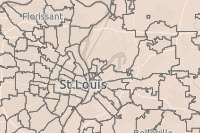

In [196]:
for item in zip_code:
    display(item)

In [197]:
zip_item = zip_code[0]

The USA_ZIP_Code layer is added as a new item.Since the item is a feature layer collection, using the layers property will give us the list of item objects.



In [198]:
for lyr in zip_item.layers:
    print(lyr.properties.name)

USA_Country
USA_State
USA_County
USA_ZipCode
USA_Tract
USA_BlockGroup


In [199]:
zip_code_layer = zip_item.layers[3]

Next, you'll use this layer to aggregate permit points.By default, the parameters are set to use the ZIP Codes as the area layer, the permits as the layer to be aggregated, and the layer style to be based on permit count. These parameters are exactly what you want.

In [200]:
from arcgis.features.summarize_data import aggregate_points

In [201]:
permit_agg_by_zip = aggregate_points(permit_layer, zip_code_layer, keep_boundaries_with_no_points=False,
                                     output_name='zip_code_aggregate')

In [202]:
permit_agg_by_zip

<Item title:"zip_code_aggregate" type:Feature Layer Collection owner:demo_deldev>

In [203]:
agg_map = gis.map('Maryland', zoomlevel=9)
agg_map

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[38.81819928400006, -76.15872999999993], zoom=9)

In [204]:
agg_map.add_layer(permit_agg_by_zip)

![](lesson2img\img1.PNG)

The new layer looks like a point layer, but it's actually a polygon layer with a point symbol. Each point represents the number of permits per ZIP Code area. Larger points indicate ZIP Codes with more permits.

In [205]:
from arcgis.features import SpatialDataFrame

In [206]:
sdf = SpatialDataFrame.from_layer(permit_agg_by_zip.layers[0])

In [207]:
sdf.head(10)

,AnalysisArea,OBJECTID,POPULATION,PO_NAME,Point_Count,SQMI,STATE,ZIP_CODE,SHAPE
0,2.356814,1,14652,Washington,6,2.36,DC,20012,"{'rings': [[[-77.0266270001359, 38.98455799965..."
1,6.248092,2,48592,Hyattsville,1,6.26,MD,20783,"{'rings': [[[-76.9414389999099, 39.02912599996..."
2,0.191061,3,219,Glen Echo,1,0.19,MD,20812,"{'rings': [[[-77.1384300001444, 38.96841399980..."
3,5.168331,4,30017,Bethesda,1145,5.17,MD,20814,"{'rings': [[[-77.0943629995527, 39.02250799964..."
4,5.360828,5,30001,Chevy Chase,586,5.35,MD,20815,"{'rings': [[[-77.0635971995511, 39.01197539974..."
5,4.607703,6,16967,Bethesda,154,4.61,MD,20816,"{'rings': [[[-77.1429960002652, 38.97162000016..."
6,13.889993,7,38385,Bethesda,732,13.89,MD,20817,"{'rings': [[[-77.1267290001432, 39.02947299977..."
7,0.978536,8,1383,Cabin John,13,0.98,MD,20818,"{'rings': [[[-77.1573989998639, 38.98250600035..."
8,9.426954,9,26858,Olney,216,9.43,MD,20832,"{'rings': [[[-77.0921479999302, 39.16957599993..."
9,22.871336,10,8380,Brookeville,40,22.87,MD,20833,"{'rings': [[[-77.0616859999089, 39.27760500037..."


In [208]:
sdf.reset_index(inplace=True)

In [211]:
sdf.head()

,index,AnalysisArea,OBJECTID,POPULATION,PO_NAME,Point_Count,SQMI,STATE,ZIP_CODE,SHAPE
0,0,2.356814,1,14652,Washington,6,2.36,DC,20012,"{'rings': [[[-77.0266270001359, 38.98455799965..."
1,1,6.248092,2,48592,Hyattsville,1,6.26,MD,20783,"{'rings': [[[-76.9414389999099, 39.02912599996..."
2,2,0.191061,3,219,Glen Echo,1,0.19,MD,20812,"{'rings': [[[-77.1384300001444, 38.96841399980..."
3,3,5.168331,4,30017,Bethesda,1145,5.17,MD,20814,"{'rings': [[[-77.0943629995527, 39.02250799964..."
4,4,5.360828,5,30001,Chevy Chase,586,5.35,MD,20815,"{'rings': [[[-77.0635971995511, 39.01197539974..."


In [212]:
sdf.Point_Count.mean()

249.42222222222222

In [213]:
sdf.Point_Count.max()

1145

In [214]:
sdf.Point_Count.min()

1

In [215]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive

items = list(sdf['PO_NAME'])
v = widgets.Dropdown(options=items)
display(v)

Dropdown(options=('Washington', 'Hyattsville', 'Glen Echo', 'Bethesda', 'Chevy Chase', 'Bethesda', 'Bethesda', 'Cabin John', 'Olney', 'Brookeville', 'Poolesville', 'Beallsville', 'Boyds', 'Dickerson', 'Rockville', 'Rockville', 'Rockville', 'Rockville', 'Potomac', 'Derwood', 'Sandy Spring', 'Ashton', 'Brinklow', 'Burtonsville', 'Spencerville', 'Clarksburg', 'Damascus', 'Germantown', 'Germantown', 'Gaithersburg', 'Gaithersburg', 'Gaithersburg', 'Washington Grove', 'Gaithersburg', 'Montgomery Village', 'Kensington', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Takoma Park', 'Mount Airy'), value='Washington')

![](lesson2img/img7.PNG)

In [216]:
v.value
x = v.index
sdf.iloc[x]['PO_NAME']
def f(x):
    return x

In [217]:

w= interactive(f, x=widgets.IntSlider(min=1,max=1145,step=1,value=sdf.Point_Count.mean(), description=(sdf.iloc[x]['PO_NAME']) + ' ' + str(sdf.iloc[x]['Point_Count'])));

In [219]:
display(w)

interactive(children=(IntSlider(value=272, description='Washington 6', max=1145, min=1), Output()), _dom_classes=('widget-interact',))

![](lesson2img/img6.PNG)

Using ipywidgets you can create a slider that displays the average count(250) approximately on the slider with the maximum count(1145) and the minimum count(1). You can  slide the slider to compare the count of the count of a specific zip code with the average count.

In [222]:
agg_layer = permit_agg_by_zip.layers[0]

Although most of the large point symbols on the map are in the southeast corner, near Washington, D.C., there are a few large points in the northwest. In particular, there is a very large circle in the ZIP Code located in Clarksburg. (If you're using different ZIP Code data, this area may be identified as ZIP Code 20871 instead.)

In [223]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive

items = list(sdf['PO_NAME'])
v = widgets.Dropdown(options=items)
display(v)

Dropdown(options=('Washington', 'Hyattsville', 'Glen Echo', 'Bethesda', 'Chevy Chase', 'Bethesda', 'Bethesda', 'Cabin John', 'Olney', 'Brookeville', 'Poolesville', 'Beallsville', 'Boyds', 'Dickerson', 'Rockville', 'Rockville', 'Rockville', 'Rockville', 'Potomac', 'Derwood', 'Sandy Spring', 'Ashton', 'Brinklow', 'Burtonsville', 'Spencerville', 'Clarksburg', 'Damascus', 'Germantown', 'Germantown', 'Gaithersburg', 'Gaithersburg', 'Gaithersburg', 'Washington Grove', 'Gaithersburg', 'Montgomery Village', 'Kensington', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Silver Spring', 'Takoma Park', 'Mount Airy'), value='Washington')

![](lesson2img/img8.PNG)

In [227]:
v.value
x = v.index
sdf.iloc[x]['PO_NAME']
def f(x):
    return x

In [228]:
w= interactive(f, x=widgets.IntSlider(min=1,max=1145,step=1,value=sdf.point_count.mean(), description=(sdf.iloc[x]['PO_NAME']) + ' ' + str(sdf.iloc[x]['Point_Count'])));

In [229]:
display(w)

interactive(children=(IntSlider(value=180, description='Clarksburg 948', max=1145, min=1), Output()), _dom_classes=('widget-interact',))

![](lesson2img/img9.PNG)

The ZIP code has 948 permits.Additionally, this area geographically corresponds to the hot spot you identified in the previous lesson. This ZIP Code is one that you'll focus on when you enrich your layer with demographic data.

Alterntively you can use see the statistics by clicing the location on the map also.

![](lesson2img\img3.PNG)

## Enrich the data

Are there demographic characteristics about the Clarksburg ZIP Code that contributed to its high growth? If so, are there other areas with those characteristics that may experience growth in the future? To answer these questions, you'll use the **Enrich Data** analysis tool. This tool adds demographic attributes of your choice to your data. Specifically, you'll add Tapestry information to each ZIP Code. <a href="https://www.esri.com/en-us/arcgis/products/tapestry-segmentation/overview">Tapestry</a> is a summary of many demographic and socioeconomic variables, including age groups and lifestyle choices. It'll teach you more about the types of people who live in your area of interest and help you better understand the reasons why growth happened where it did.

In [230]:
from arcgis.features.enrich_data import enrich_layer

In [231]:
enrich_aggregate = enrich_layer(agg_layer, analysis_variables=["AtRisk.TSEGNAME"],
             output_name="enriched_aggregate")

In [232]:
enrich_aggregate_map = gis.map('Maryland', zoomlevel=8)

In [233]:
enrich_aggregate_map

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[38.81819928400006, -76.15872999999993], zoom=8)

![](lesson2img\img10.PNG)

In [234]:
enrich_aggregate_map.add_layer(enrich_aggregate,  {'renderer':'ClassedSizeRenderer',
                                             'filed_name':'ZIP_CODE',
                                             'opacity':0.75})

Point to some of the ZIP Codes.

Not only has the symbology changed, but now the Tapestry segment is displayed when you point to a ZIP Code. The Tapestry segments have names such as Enterprising Professionals and Savvy Suburbanites. You can look up more information about each segment, including its specific demographic characteristics, on the<a href="http://doc.arcgis.com/en/esri-demographics/data/tapestry-segmentation.htm"> Tapestry Segmentation help page</a>.

 What Tapestry segment is dominant for the Clarksburg ZIP Code where major growth occurred?
 
Point to the Clarksburg ZIP Code.

![](lesson2img/img5.PNG)

According to the pop-up, Boomburbs is the dominant Tapestry segment for the ZIP Code. Boomburbs have many young professionals with families living in affordable new housing. This description may explain why the area saw such rapid residential growth in 2011. It's possible that other ZIP Codes with similar demographic profiles may experience rapid growth in the near future.

Point to the ZIP Code directly southwest of Clarksburg.

This ZIP Code is in Boyds. It also has the Boomburbs Tapestry segment. However, its number of permits has been relatively low since 2010. The county may be able to anticipate a similar spike in permit activity in this area.

![](lesson2img/img .PNG)

In [73]:
enrich_aggregate

<Item title:"enrich aggregate" type:Feature Layer Collection owner:demo_deldev>

In [72]:
enrich_aggregate.share(everyone=True)

{'itemId': '6872cc4c6e9148e096138c3924d396ed', 'notSharedWith': []}

Using the `share()` method you can shae your work with your organization.

In these lessons, you usedArcGIS python API to explore and analyze permit data for Montgomery County, Maryland. You answered questions about your data's spatial and temporal trends and located areas of the county with rapid growth. You compared your findings with demographic data, came to conclusions about the possible causes of growth, and even predicted an area that may experience similar growth in the future based on shared demographic characteristics.